In [1]:
#!pip install matplotlib
#!pip install scipy
#!pip install pip install split-folders

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils import create_generators, build_model


os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='1' # Select the GPU to use

gpus = tf.config.list_physical_devices('GPU') # Use only the required GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2024-05-17 00:56:20.565893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuration

In [3]:
DATASET = './dataset'  # path to the dataset
SPLITTED_DATASET = DATASET+'_splitted'

CLASS_NAMES = np.array([item for item in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, item))])
NUM_CLASSES = len(CLASS_NAMES)

MODEL = 'mobilenet_v2' # mobilenet_v2, resnet50, vgg16 or inception_v3
SIZE = 224  # Image resolution
BATCH_SIZE = 32  # size of the readed batches from generator (must fit on system memory)
VAL_SPLIT = 0.15  # fraction of the images used for validation
TEST_SPLIT = 0.15  # fraction of the images used for testing
SAVED_MODEL_NAME = 'trained_'+MODEL+'_'+str(SIZE) # Name for the saved model




# Import desired model and preprocess function
# Could use switch if pyython>=3.10
if MODEL == 'mobilenet_v2':
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as model, preprocess_input
elif MODEL == 'resnet50':
    from tensorflow.keras.applications.resnet50 import ResNet50 as model, preprocess_input
elif MODEL == 'vgg16':
    from tensorflow.keras.applications.vgg16 import VGG16 as model, preprocess_input
elif MODEL == 'inception_v3':
    from tensorflow.keras.applications.inception_v3 import InceptionV3 as model, preprocess_input
else:
    print('Select a valid model')
    exit(0)

# Image loading

In [4]:
##########           Image generators           ##########

# Just execute when you need to generate the splitted data. Comment if not.
#import splitfolders # !pip install pip install split-folders
#splitfolders.ratio(DATASET, seed=123, output=SPLITTED_DATASET, ratio=(1-VAL_SPLIT-TEST_SPLIT, VAL_SPLIT, TEST_SPLIT))

train_generator, validation_generator, test_generator = create_generators(preprocess_input, SPLITTED_DATASET, BATCH_SIZE, SIZE)

Loading train data
Found 2796 images belonging to 4 classes.
Loading validation data
Found 597 images belonging to 4 classes.
Loading test data
Found 604 images belonging to 4 classes.
Images shape: (32, 224, 224, 3)


# Training

In [5]:
##########          CNN Construction           ##########

INPUT_SHAPE = (SIZE, SIZE, 3)

# Build and compile the model
model = build_model(model, INPUT_SHAPE, NUM_CLASSES)

2024-05-17 00:56:31.179594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


In [6]:
##########           Training           ##########

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01, restore_best_weights=True)

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

save_path = './trained_models/'+SAVED_MODEL_NAME+'.keras'
print('Saving model to:', save_path)
model.save(save_path)

Epoch 1/20


2024-05-17 00:56:41.375221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-05-17 00:56:44.657770: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5d0401f140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 00:56:44.657833: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-05-17 00:56:44.697213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 00:56:45.264528: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 [==============================] - 167s 2s/step - loss: 0.6477 - accuracy: 0.7761 - auc: 0.9349 - precision: 0.8063 - recall: 0.7489 - true_positives: 2094.0000 - true_negatives: 7885.0000 - false_positives: 503.0000 - false_negatives: 702.0000 - val_loss: 0.2597 - val_accuracy: 0.9129 - val_auc: 0.9865 - val_precision: 0.9245 - val_recall: 0.9028 - val_true_positives: 539.0000 - val_true_negatives: 1747.0000 - val_false_positives: 44.0000 - val_false_negatives: 58.0000
Epoch 2/20
88/88 [==============================] - 156s 2s/step - loss: 0.2205 - accuracy: 0.9245 - auc: 0.9901 - precision: 0.9328 - recall: 0.9181 - true_positives: 2567.0000 - true_negatives: 8203.0000 - false_positives: 185.0000 - false_negatives: 229.0000 - val_loss: 0.1865 - val_accuracy: 0.9313 - val_auc: 0.9926 - val_precision: 0.9406 - val_recall: 0.9280 - val_true_positives: 554.0000 - val_true_negatives: 1756.0000 - val_false_positives: 35.0000 - val_false_negatives: 43.0000
Epoch 3/20
88/88 [=========

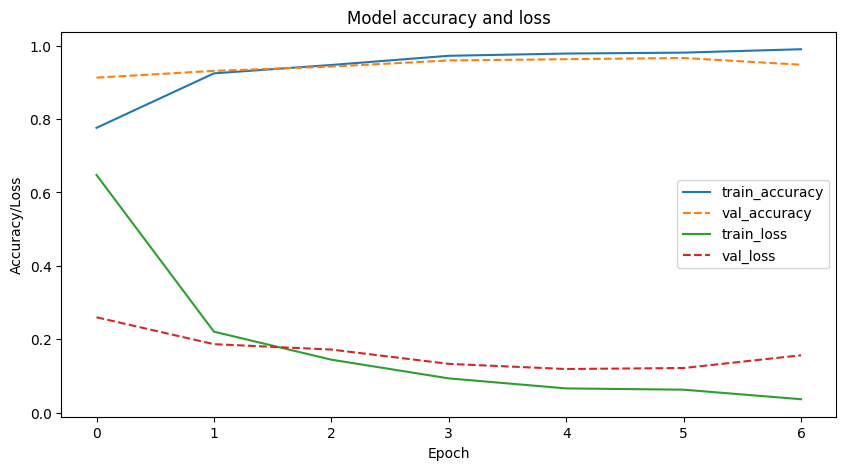

In [7]:
# Plot training & validation accuracy and loss values in a single plot with the four metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], linestyle='dashed')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='dashed')

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='best')



# Model testing

In [8]:
#########           Model test           ##########
from keras.models import load_model

'''
path = './trained_models/'+SAVED_MODEL_NAME+'.keras'
model = load_model(path, compile=True)
    
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = val_datagen.flow_from_directory(SPLITTED_DATASET+'/test',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         target_size=(SIZE,SIZE)
                                                    )

'''

# Evaluate on Validation data
scores = model.evaluate(test_generator)

for name, value in zip(model.metrics_names, scores):
  print(name, ': ', value)

19/19 [==============================] - 29s 2s/step - loss: 0.1753 - accuracy: 0.9354 - auc: 0.9941 - precision: 0.9369 - recall: 0.9338 - true_positives: 564.0000 - true_negatives: 1774.0000 - false_positives: 38.0000 - false_negatives: 40.0000
loss :  0.17531165480613708
accuracy :  0.9354304671287537
auc :  0.9941132068634033
precision :  0.9368770718574524
recall :  0.9337748289108276
true_positives :  564.0
true_negatives :  1774.0
false_positives :  38.0
false_negatives :  40.0


# Support code

### Detect and remove corrupted images from the dataset